Optimal Transport with Linear Programming
=========================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This numerical tours details how to solve the discrete optimal transport
problem (in the case of measures that are sums of Diracs) using linear
programming.

You need to install [CVXPY](https://www.cvxpy.org/). _Warning:_ seems to not be working on Python 3.7, use rather 3.6.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

Optimal Transport of Discrete Distributions
------------------------------------------

We consider two dicretes distributions
$$ \al = \sum_{i=1}^n a_i \de_{x_i} \qandq 
   \be = \sum_{j=1}^m b_j \de_{y_j}. $$
   
where $n,m$ are the number of points, $\de_x$ is the Dirac at
location $x \in \RR^d$, and $(x_i)_i, (y_j)_j$ are the positions of the diracs in $\RR^d$. 

Dimensions $(n,m)$ of the coulds.

In [9]:
n = 60
m = 80

Generate the point clouds $X=(x_i)_i$ and $Y=(y_j)_j$.

In [10]:
gauss = lambda q,a,c: a*np.random.randn(2, q) + np.transpose(np.tile(c, (q,1)))
X = np.random.randn(2,n)*.3
Y = np.hstack((gauss(int(m/2),.5,[0,1.6]),np.hstack((gauss(int(m/4),.3,[-1,-1]),gauss(int(m/4),.3,[1,-1])))))

Generate the weights $a,b$.

In [11]:
normalize = lambda a: a/np.sum(a)
a = normalize(np.random.rand(n, 1))
b = normalize(np.random.rand(m, 1))

Helper function for display of clouds.

In [12]:
myplot = lambda x,y,ms,col: plt.scatter(x,y, s=ms*20, edgecolors="k", c=col, linewidths=2)

Display the point clouds.
The size of each dot is proportional to its probability density weight.

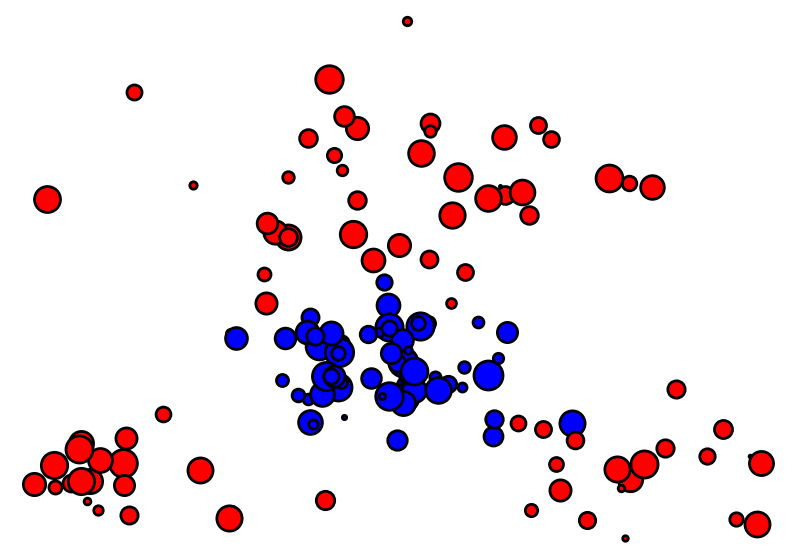

In [13]:
plt.figure(figsize = (10,7))
plt.axis("off")
for i in range(len(a)):
    myplot(X[0,i], X[1,i], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Y[0,j], Y[1,j], b[j]*len(b)*10, 'r')
plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.show()

Compute the cost matrix $C_{i,j} := \norm{x_i-x_j}^2$.

In [14]:
def distmat(x,y):
    return np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y)
C = distmat(X,Y)

Define the optimiztion variable $P$.

In [15]:
P = cp.Variable((n,m))

Define the set of discrete couplings between $\al$ and $\be$
$$ U(a,b) := \enscond{ P \in \RR_+^{n \times m} }{
     \forall i, \sum_j P_{i,j} = a_i, \:
     \forall j, \sum_i P_{i,j} = b_j }. $$

In [16]:
u = np.ones((m,1))
v = np.ones((n,1))
U = [0 <= P, cp.matmul(P,u)==a, cp.matmul(P.T,v)==b]

The Kantorovitch formulation of the optimal transport reads
$$ P^\star \in \uargmin{P \in U(a,b)} \sum_{i,j} P_{i,j} C_{i,j}.  $$
Solve it using CVXPY

In [17]:
objective = cp.Minimize( cp.sum(cp.multiply(P,C)) )
prob = cp.Problem(objective, U)
result = prob.solve()

/home/grothendieck/PycharmProjects/NumericalToursOT/venv/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


An optimal coupling $P^\star$ can be shown to be a sparse matrix
with less than $n+m-1$ non zero entries. An entry $P_{i,j}^\star \neq 0$
should be understood as a link between $x_{i}$
and $y_{j}$ where an amount of mass equal to $P_{i,j}^\star$ is transfered.

Check that the number of non-zero entries in $P^\star$ is $n+m-1$. Beware that we are using an interior point method here, so that entries of $P^\star$ are nevery exactly 0.

In [18]:
print("Number of non-zero: %d (n + m-1 = %d)" %(len(P.value[P.value>1e-5]), n + m-1))

Number of non-zero: 139 (n + m-1 = 139)


Display the solution coupling.

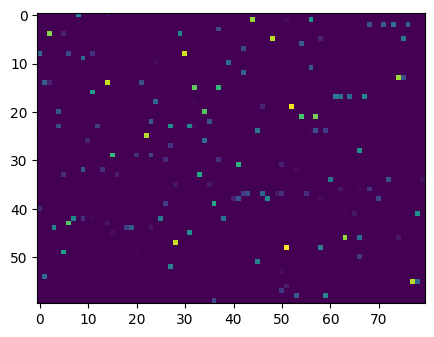

In [19]:
plt.figure(figsize = (5,5))
plt.imshow(P.value);

Display the connexion defined by the optimal coupling.

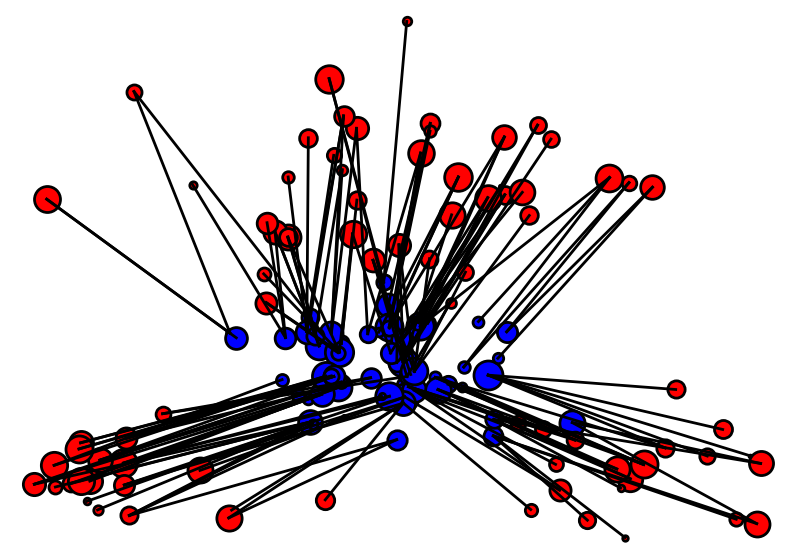

In [20]:
I,J = np.nonzero(P.value>1e-5)
plt.figure(figsize = (10,7))
plt.axis('off')
for k in range(len(I)):
    h = plt.plot(np.hstack((X[0,I[k]],Y[0,J[k]])),np.hstack(([X[1,I[k]], Y[1,J[k]]])),'k', lw = 2)
for i in range(len(a)):
    myplot(X[0,i], X[1,i], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Y[0,j], Y[1,j], b[j]*len(b)*10, 'r')
plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.show()

Displacement Interpolation
--------------------------
For any $t \in [0,1]$, one can define a distribution $\mu_t$ such
that $t \mapsto \mu_t$ defines a geodesic for the Wasserstein metric.


Since the $W_2$ distance is a geodesic distance, this geodesic path solves the
following variational problem

$$ \mu_t = \uargmin{\mu} (1-t)W_2(\al,\mu)^2 + t W_2(\be,\mu)^2. $$
This can be understood as a generalization of the usual Euclidean
barycenter to barycenter of distribution. Indeed, in the case that
$\al = \de_{x}$ and $\be=\de_y$, one has $\mu_t=\de_{x_t}$ where $ x_t =
(1-t)x+t y $.


Once the optimal coupling $P^\star$ has been computed, the
interpolated distribution is obtained as

$$ \mu_t = \sum_{i,j} P^\star_{i,j} \de_{(1-t)x_{i} + t y_{j}}. $$

Find the $i,j$ with non-zero $P_{i,j}^\star$.

In [21]:
I,J = np.nonzero(P.value>1e-5)
Pij = P.value[I,J]

Display the evolution of $\mu_t$ for a varying value of $t \in [0,1]$.

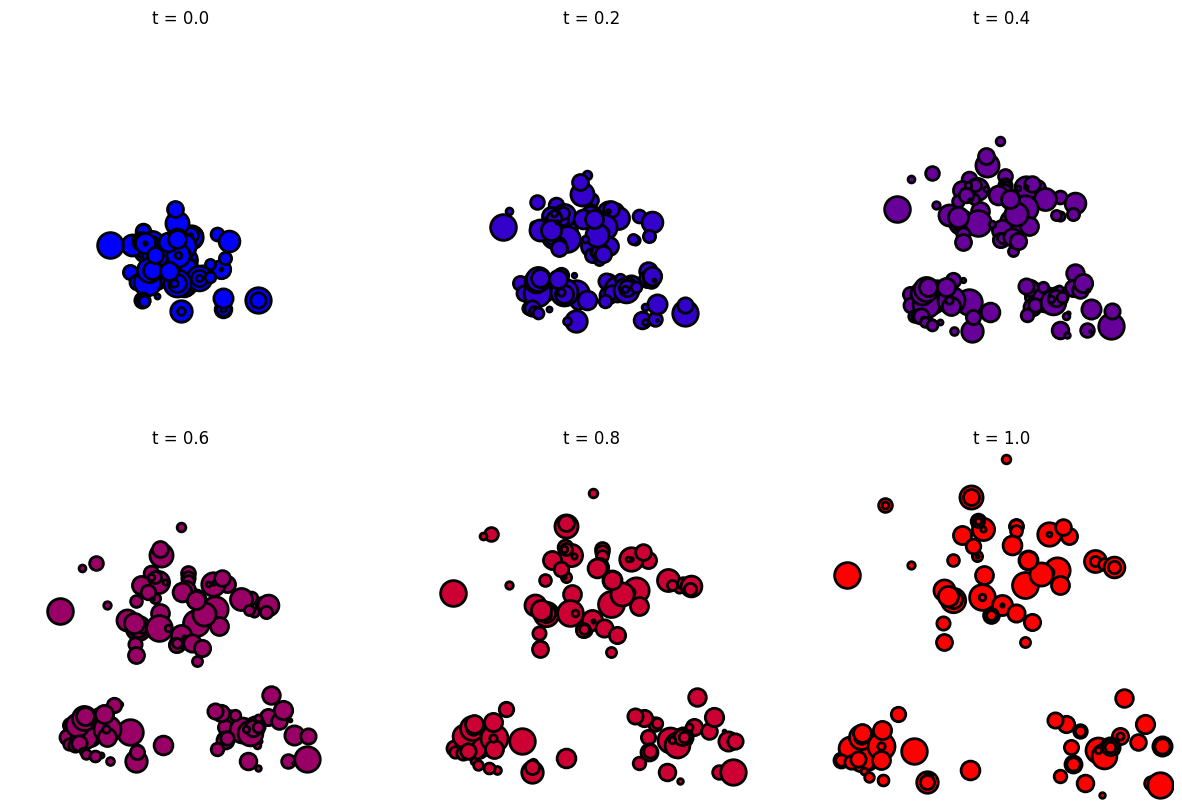

In [22]:
plt.figure(figsize =(15,10))
tlist = np.linspace(0, 1, 6)
for i in range(len(tlist)):
    t = tlist[i]
    Xt = (1-t)*X[:,I] + t*Y[:,J]
    plt.subplot(2,3,i+1)
    plt.axis("off")
    for j in range(len(Pij)):
        myplot(Xt[0,j],Xt[1,j],Pij[j]*len(Pij)*6,[[t,0,1-t]])
    plt.title("t = %.1f" %t) 
    plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
    plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.show()

Optimal Assignement
-------------------
In the case where $n=m$ and the weights are uniform $a_{i}=1/n, b_{j}=1/n$, one can show that there is at least one optimal transport coupling which is actually a
permutation matrix. This properties comes from the fact that
the extremal point of the polytope $U(1,1)$ are permutation matrices.


This means that there exists an optimal permutation $\si^\star \in \Sigma_n$ such
that
$$ P^\star_{i,j} = \choice{
      1 \qifq j=\si^\star(i), \\
      0 \quad\text{otherwise}.
  } $$
  
where $\Si_n$ is the set of permutation (bijections) of
$\{1,\ldots,n\}$.


This permutation thus solves the so-called optimal assignement problem
$$ \si^\star \in \uargmin{\si \in \Sigma_n}
      \sum_{i} C_{i,\si(j)}. $$

Use the same number of points.

In [23]:
n = 40
m = n

Compute points clouds.

In [24]:
X = np.random.randn(2,n)*.3
Y = np.hstack((gauss(int(m/2),.5,[0,1.6]),np.hstack((gauss(int(m/4),.3,[-1,-1]),gauss(int(m/4),.3,[1,-1])))))

Constant distributions.

In [25]:
a = np.ones([n,1])/n
b = a

Compute the weight matrix $ (C_{i,j})_{i,j}. $

In [26]:
C = distmat(X,Y)

Display the coulds.

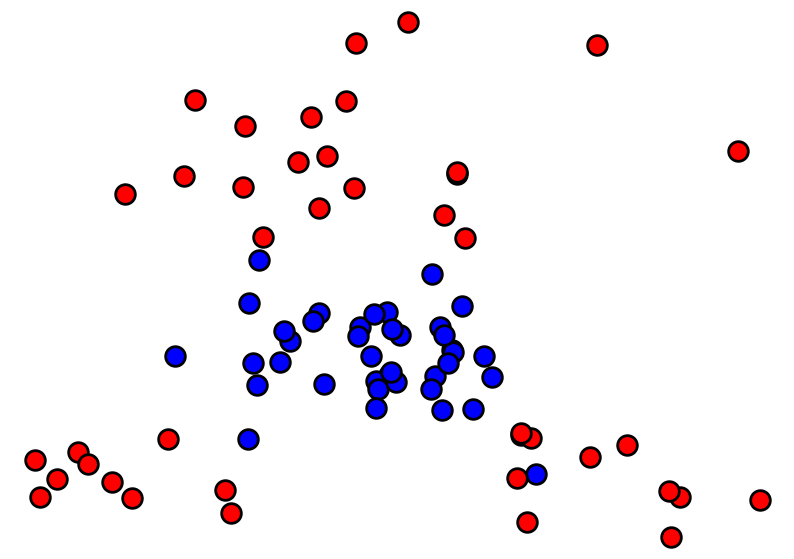

In [27]:
plt.figure(figsize = (10,7))
plt.axis('off')
myplot(X[0,:],X[1,:],10,'b')
myplot(Y[0,:],Y[1,:],10,'r')
plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.show()

Solve the optimal transport.

In [28]:
P = cp.Variable((n,m))
u = np.ones((m,1))
v = np.ones((n,1))
U = [0 <= P, cp.matmul(P,u)==a, cp.matmul(P.T,v)==b]
objective = cp.Minimize( cp.sum(cp.multiply(P,C)) )
prob = cp.Problem(objective, U)
result = prob.solve()

Show that $P$ is a binary permutation matrix.

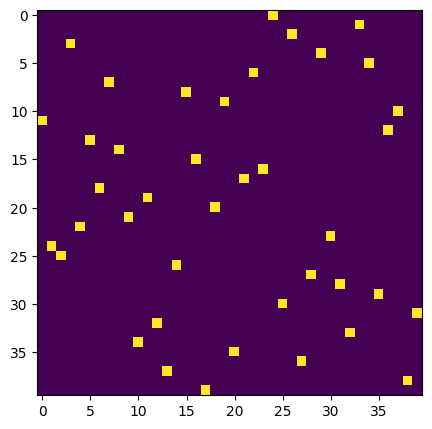

In [29]:
plt.figure(figsize = (5,5))
plt.imshow(P.value);

Display the optimal assignement.

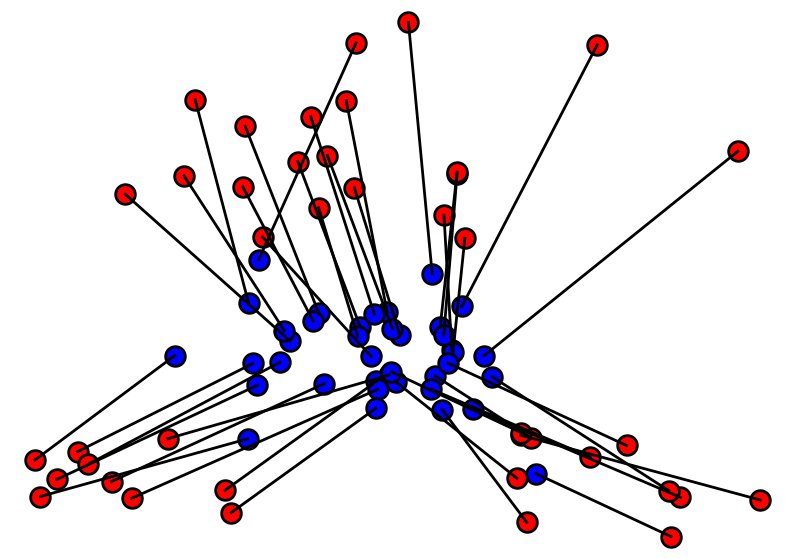

In [30]:
I,J = np.nonzero(P.value>1e-5)
plt.figure(figsize = (10,7))
plt.axis('off')
for k in range(len(I)):
    h = plt.plot(np.hstack((X[0,I[k]],Y[0,J[k]])),np.hstack(([X[1,I[k]], Y[1,J[k]]])),'k', lw = 2)
myplot(X[0,:], X[1,:], 10, 'b')
myplot(Y[0,:], Y[1,:], 10, 'r')
plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.show()